In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score


Loading in the dataset

In [ ]:
df = pd.read_csv('spam_ham_dataset.csv')


In [ ]:
df.head(7)

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0
5,2949,ham,Subject: ehronline web address change\r\nthis ...,0
6,2793,ham,Subject: spring savings certificate - take 30 ...,0


In [ ]:
df.shape

(5171, 4)

In [ ]:
freq_table=pd.crosstab(df['label'],'no_of_label')

freq_table

col_0,no_of_label
label,
ham,3672
spam,1499


In [ ]:
freq_table=freq_table/len(df)
freq_table

col_0,no_of_label
label,
ham,0.710114
spam,0.289886


In [ ]:
data=df['label'].value_counts()
print(data)

ham     3672
spam    1499
Name: label, dtype: int64


In [ ]:
# ham
quotient=3676/5172
percent=quotient*100
print(percent)

71.07501933488012


In [ ]:
#spam
quotient=1499/5172
percent=quotient*100
print(percent)

28.982985305491106


The dataset has 5171 records and 4 columns

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


Both columns are of object datatype

In [ ]:
# Checking if any duplicate records are present
duplicate=df[df.duplicated()]
duplicate

,Unnamed: 0,label,text,label_num


In [ ]:
# Again check if any duplicate records are left
duplicate = df[df.duplicated()]
duplicate

,Unnamed: 0,label,text,label_num


In [ ]:
df.describe(include='object')

,label,text
count,5171,5171
unique,2,4993
top,ham,Subject: calpine daily gas nomination\r\n>\r\n...
freq,3672,20


In [ ]:
# Checking for null values
df.isnull().sum()

Unnamed: 0    0
label         0
text          0
label_num     0
dtype: int64

The dataset doesn't have any missing values

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


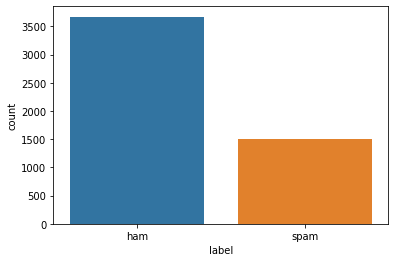

In [ ]:
# Visualizing the disribution of ham and spam messages
sns.countplot(df['label'])

It can be seen that the count of spam messages is much less than ham.

Text Preprocessing

In [ ]:
# Expanding contractions

# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not",
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

In [ ]:
# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

In [ ]:
# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

In [ ]:
# Expanding Contractions in the reviews
df['text'] = df['text'].apply(lambda x:expand_contractions(x))

In [ ]:
# Converting text to lowercase
df['text'] = df['text'].apply(lambda x:x.lower())

In [ ]:
# Removing digits and words containing digits
df['text'] = df['text'].apply(lambda x: re.sub('\w*\d\w*','', x))

In [ ]:
# Removing punctuations
df['text'] = df['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

In [ ]:
# Removing extra spaces

df['text']=df['text'].apply(lambda x: re.sub(' +',' ',x))

In [ ]:
# Displaying the text after cleaning
for index,text in enumerate(df['text'][0:3]):
    print('Review %d:\n'%(index+1), text)

Review 1:
 subject enron methanol meter 
this is a follow up to the note i gave you on monday preliminary
flow data provided by daren 
please override pop s daily volume presently zero to reflect daily
activity you can obtain from gas control 
this change is needed asap for economics purposes 
Review 2:
 subject hpl nom for january 
 see attached file hplnol xls 
 hplnol xls
Review 3:
 subject neon retreat
ho ho ho we re around to that most wonderful time of the year neon leaders retreat time 
i know that this time of year is extremely hectic and that it s tough to think about anything past the holidays but life does go on past the week of december through january and that s what i d like you to think about for a minute 
on the calender that i handed out at the beginning of the fall semester the retreat was scheduled for the weekend of january but because of a youth ministers conference that brad and dustin are connected with that week we re going to change the date to the following we

In [ ]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

In [ ]:
def lemmatize_text(text):
    rev = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text) if w not in stopwords.words('english')]
    rev = ' '.join(rev)
    return rev
    df['text'] = df.text.apply(lemmatize_text)

In [ ]:
# Creating text variable for ham
df_ham = df[df.label == 'ham']

text_ham = " ".join(text for text in df_ham['text'])

In [ ]:
# Creating text variable for spam
df_spam = df[df.label == 'spam']

text_spam = " ".join(text for text in df_spam['text'])

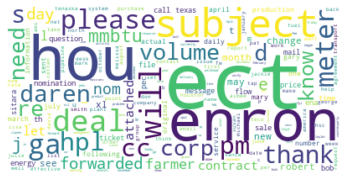

In [ ]:
# Creating wordcloud for ham
ham_cloud = WordCloud(collocations = False, background_color = 'white').generate(text_ham)
plt.imshow(ham_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

enron,hou,ect,subject,please,hpletc. are some of the most common words in ham messages.

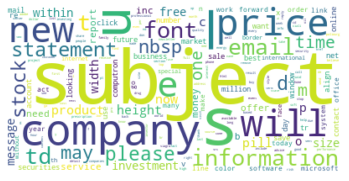

In [ ]:
# Creating wordcloud for spam
spam_cloud = WordCloud(collocations = False, background_color = 'white').generate(text_spam)
plt.imshow(spam_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

investment,company,subject,new,nbspetc. are some of the most common words in spam messages.


In [ ]:
# Creating a Bag of Words model
cv = CountVectorizer()
X = cv.fit_transform(df['text']).toarray()

In [ ]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
# Encoding dependent variable
le = LabelEncoder()
df["labek"] = le.fit_transform(df["label"])    # ham->0 and spam->1

In [ ]:
y = df["label"]

In [ ]:
# Splitting the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (4136, 45781)
X_test: (1035, 45781)
y_train: (4136,)
y_test: (1035,)


In [ ]:
# Training the model using Naive Bayes classifier
nb = MultinomialNB().fit(X_train, y_train)

In [ ]:
print("Score of train data:", nb.score(X_train, y_train))
print("Score of test data:", nb.score(X_test, y_test))

Score of train data: 0.988394584139265
Score of test data: 0.9768115942028985


The model performs well on train as well as test data

In [ ]:
y_pred = nb.predict(X_test)
y_pred

array(['ham', 'spam', 'ham', ..., 'spam', 'ham', 'ham'], dtype='<U4')

In [ ]:
f1_score = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)
print("F1 Score:", f1_score)
print("Accuracy Score:", accuracy)





F1 Score: 0.9767383422382769
Accuracy Score: 0.9768115942028985


In [ ]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ham       0.98      0.99      0.98       742
        spam       0.97      0.95      0.96       293

    accuracy                           0.98      1035
   macro avg       0.97      0.97      0.97      1035
weighted avg       0.98      0.98      0.98      1035



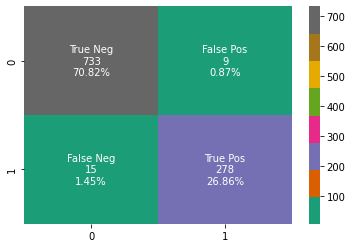

In [ ]:
cm = confusion_matrix(y_test, y_pred)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Dark2')